In [1]:
import qiskit
import os
import matplotlib.pyplot as plt
import numpy as np
import copy
import re
from collections import defaultdict

from qiskit.visualization import plot_histogram

VERBOSE = False
printv = lambda text: print(text) if VERBOSE else None

In [2]:
if not qiskit.IBMQ.active_account():
    qiskit.IBMQ.enable_account(os.environ["IBMQ_TOKEN"])

In [3]:
# qiskit.IBMQ.providers()
# qiskit.IBMQ.providers()[1].backends()

In [4]:
lagos = qiskit.IBMQ.providers()[1].get_backend("ibm_lagos")
ism = lagos.defaults().instruction_schedule_map

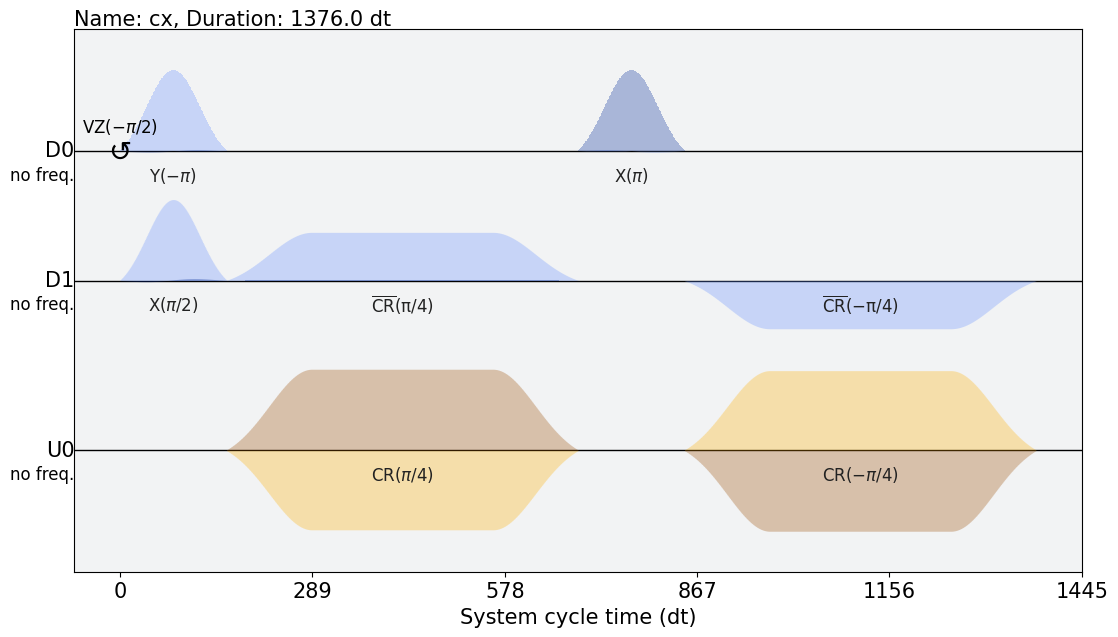

In [5]:
cnot_schedule = ism.get("cx", qubits=(0, 1))
cnot_schedule.draw()

## Qiskit Pulse: Flip amplitude

In [6]:
# schedule.instructions of form ((start_time, inst), (start_time, inst), ...)
cnot_copy = copy.deepcopy(cnot_schedule)
for idx, (start, instruction) in enumerate(cnot_copy.instructions):
    print(f"({idx}) {start}: {instruction}\n")

(0) 0: ShiftPhase(1.5707963267948966, DriveChannel(0))

(1) 0: ShiftPhase(1.5707963267948966, ControlChannel(1))

(2) 0: Play(Drag(duration=160, amp=(-5.0087850715881974e-17-0.2726655595760622j), sigma=40, beta=-1.0274239451049492, name='Ym_d0'), DriveChannel(0), name='Ym_d0')

(3) 0: Play(Drag(duration=160, amp=(0.10007125765951656+0.000855337357655086j), sigma=40, beta=-1.406580665674364, name='X90p_d1'), DriveChannel(1), name='X90p_d1')

(4) 160: Play(GaussianSquare(duration=528, amp=(0.059534361985564166+0.00028203014994330713j), sigma=64, width=272, name='CR90p_d1_u0'), DriveChannel(1), name='CR90p_d1_u0')

(5) 160: Play(GaussianSquare(duration=528, amp=(-0.681022576091795+0.6931477142917915j), sigma=64, width=272, name='CR90p_u0'), ControlChannel(0), name='CR90p_u0')

(6) 688: Play(Drag(duration=160, amp=(0.2726655595760622+0j), sigma=40, beta=-1.0274239451049492, name='Xp_d0'), DriveChannel(0), name='Xp_d0')

(7) 848: Play(GaussianSquare(duration=528, amp=(-0.059534361985564166-

In [7]:
instruction_id = 6
print(cnot_copy.instructions[instruction_id], "\n")
print(cnot_copy.instructions[instruction_id][1].pulse.amp)

(688, Play(Drag(duration=160, amp=(0.2726655595760622+0j), sigma=40, beta=-1.0274239451049492, name='Xp_d0'), DriveChannel(0), name='Xp_d0')) 

(0.2726655595760622+0j)


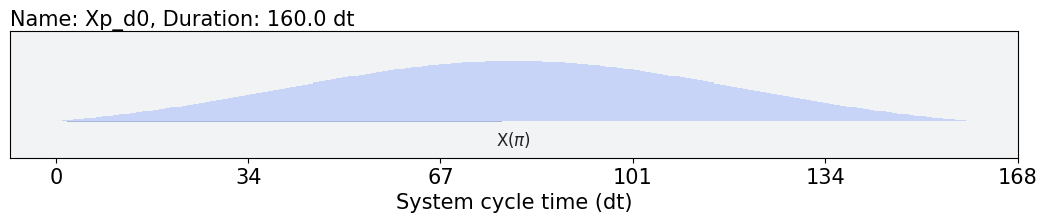

In [8]:
cnot_copy.instructions[instruction_id][1].pulse.draw()

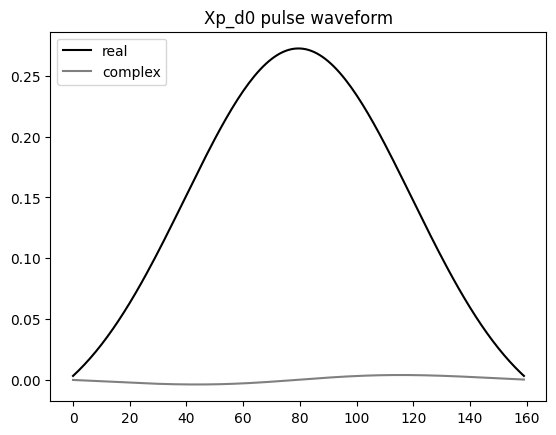

In [9]:
samples = cnot_copy.instructions[instruction_id][1].pulse.get_waveform().samples
plt.plot(samples.real, color="k", label="real")
plt.plot(samples.imag, color="gray", label="complex")
plt.legend(loc="upper left")
plt.title(f"{cnot_copy.instructions[instruction_id][1].name} pulse waveform");

In [10]:
try:
    cnot_copy.instructions[instruction_id][1].pulse.amp *= -1
except AttributeError as e:
    print(f"Attribute Error: {e}")

Attribute Error: can't set attribute


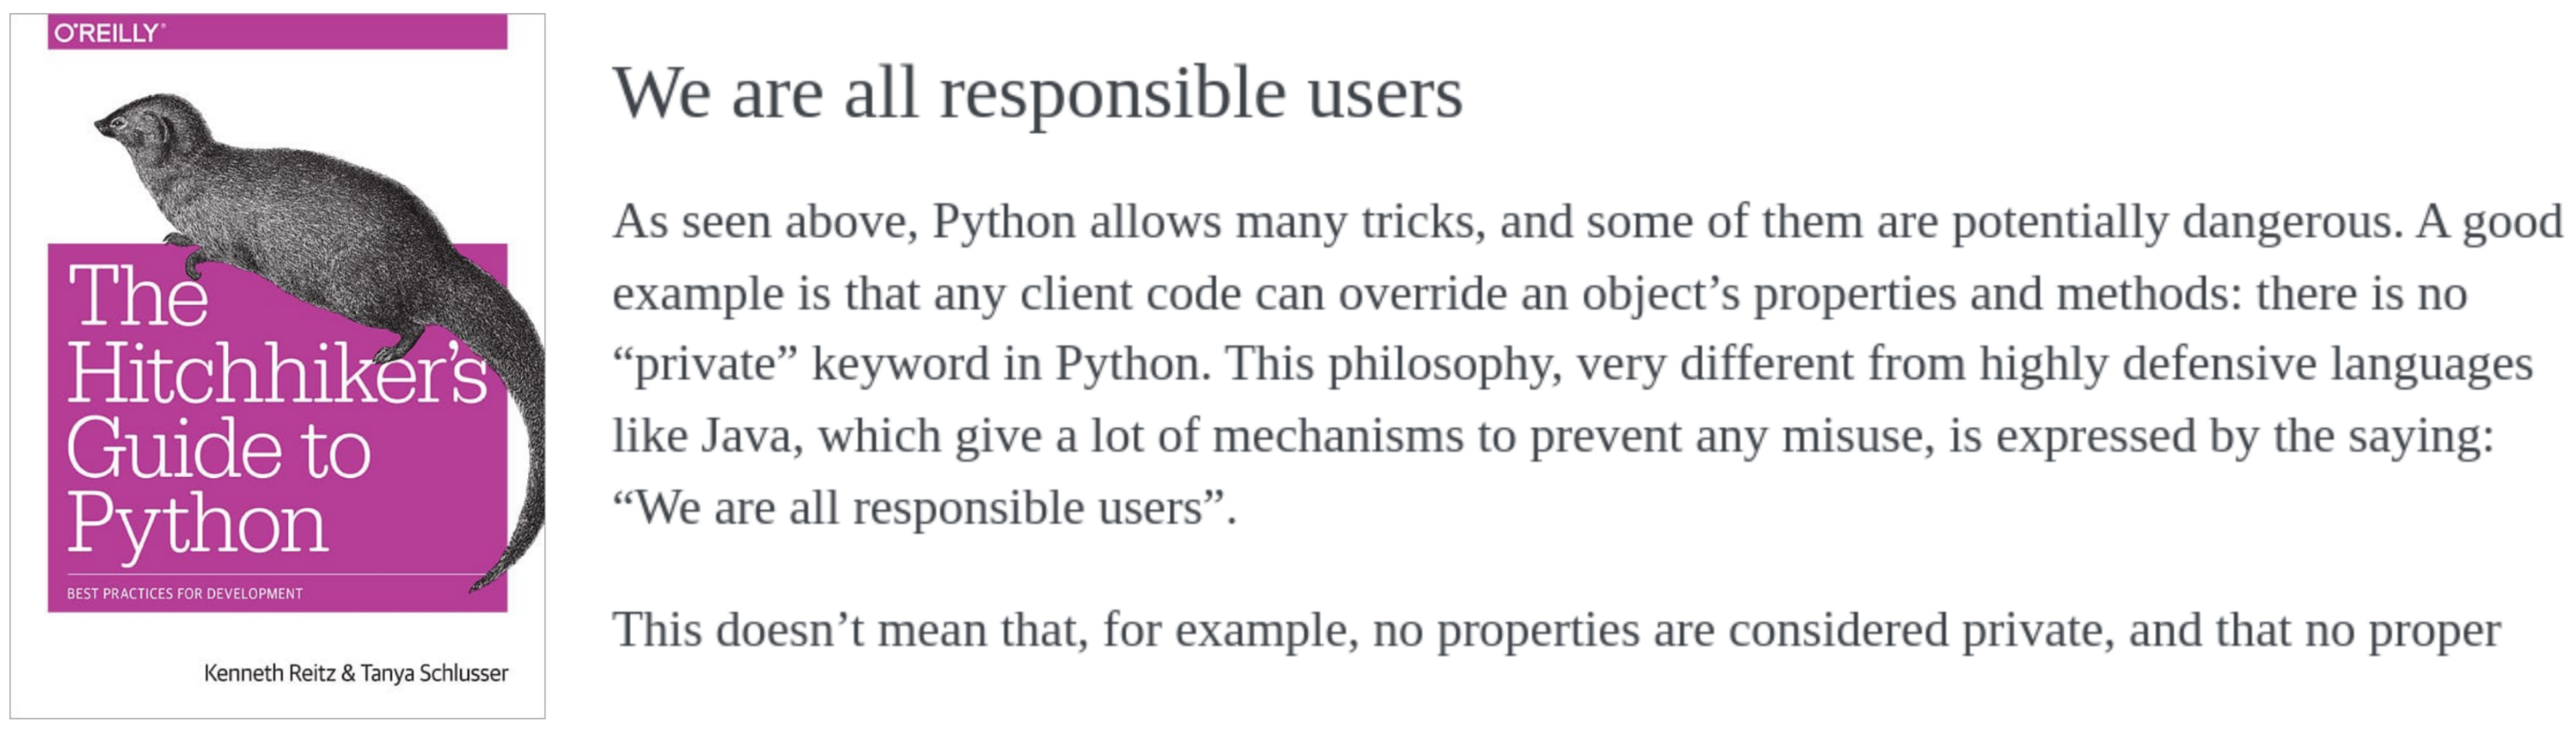

### Still -- it's a good idea to know: what restraints do we need on pulse parameters?

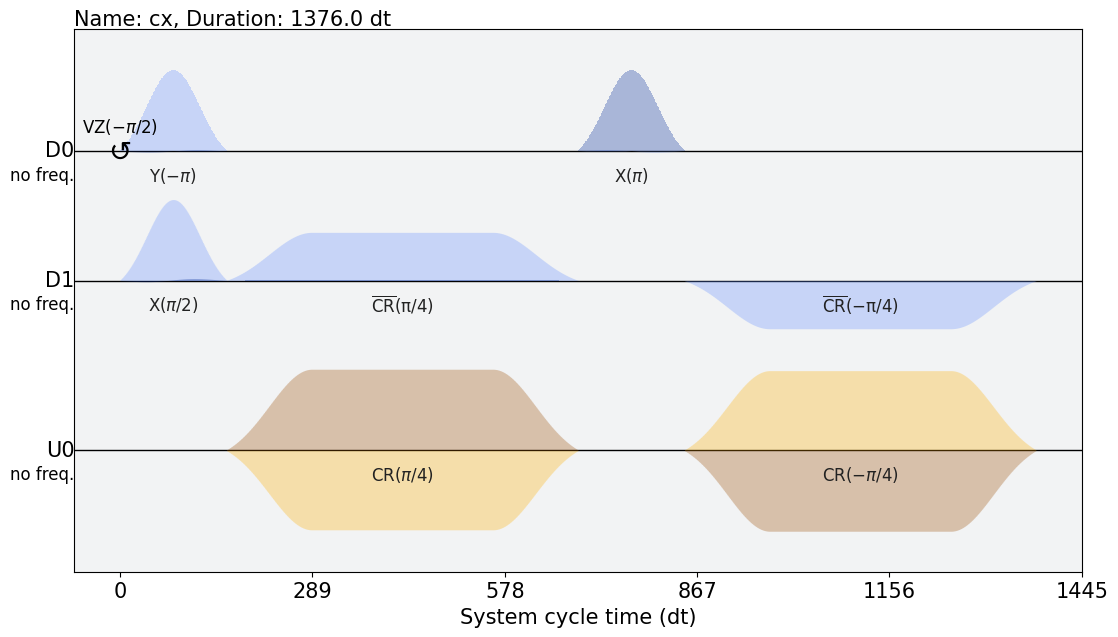

In [11]:
cnot_copy.draw()

In [12]:
cnot_copy.instructions[instruction_id][1].pulse._amp *= -1
cnot_copy.instructions[instruction_id][1].pulse.amp

(-0.2726655595760622+0j)

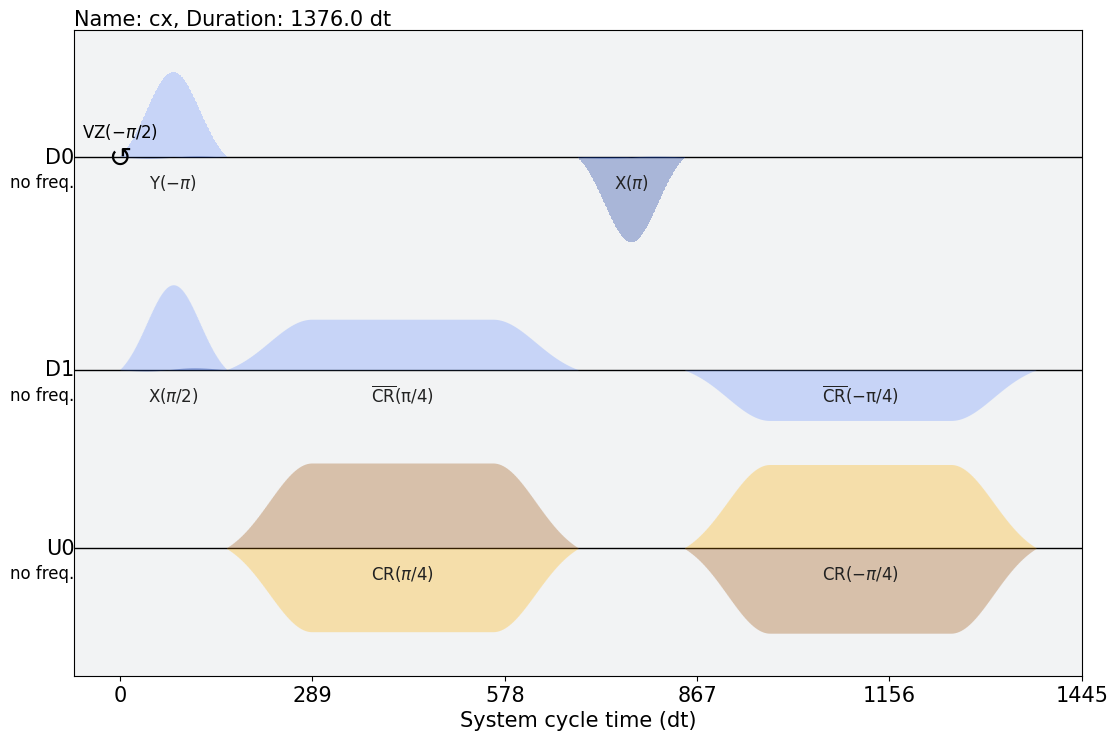

In [13]:
cnot_copy.draw()

## (SuperstaQ)PulseVisualization: flip amplitude

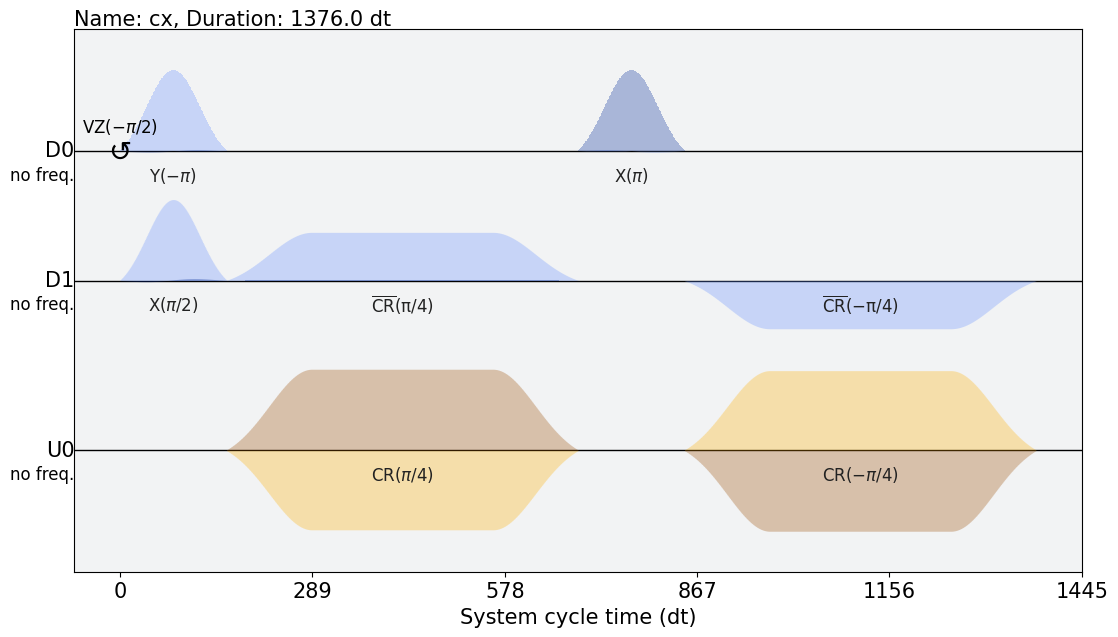

In [14]:
cnot_schedule.draw()

In [15]:
# Pulse Manipulator
"""
PulseManipulator: Quickly and easily manipulate Qiskit pulse schedules.
"""

import qiskit
import os
import matplotlib.pyplot as plt
import numpy as np
import re
from typing import Dict
from collections import defaultdict
from copy import deepcopy

VERBOSE = False
printv = lambda text: print(text) if VERBOSE else None

class PulseManipulator:
    """
    This class is a pulse schedule wrapper that allows more precise manipulation.
    """

    def __init__(self, schedule=None, backend=None):
        """Constructs intial PulseManipulator using qiskit pulse schedule."""
        if not isinstance(schedule, qiskit.pulse.Schedule):
            raise ValueError("Input schedule must be of type qiskit.pulse.Schedule.")

        if not isinstance(backend, qiskit.providers.Backend):
            raise ValueError("Input backend must be of type qiskit.providers.Backend")

        self._init_schedule = deepcopy(schedule)
        self._schedule = deepcopy(schedule)
        self._backend = backend
        self._id_to_inst_map = None
        self._set_id_to_instruction_map()
        self._coinciding_channels = self._get_coinciding_channels_map()


    @property
    def duration(self):
        """Returns the duration for the instruction."""
        return self._schedule.duration


    @property
    def name(self, inst_id=None):
        """Returns the name for the instruction."""
        _, inst = self._extract_instruction(inst_id=inst_id)
        return inst.name


    def get_start_time(self, inst_id=None):
        """Returns the start time for the instruction."""
        start_time, _ = self._extract_instruction(inst_id=inst_id)
        return start_time


    def get_stop_time(self, inst_id=None):
        """Returns the stop time for the instruction."""
        _, instruction = self._extract_instruction(inst_id=inst_id)
        return self.get_start_time(inst_id=inst_id) + instruction.duration


    def draw(self, time_range=None):
        """Draws pulse schedule to screen, inheriting qiskit's functionality."""
        # TODO: include a "pretty" draw
        return self._schedule.draw(time_range=time_range)


    def append(self, instruction, inplace=False):
        """Appends instruction to the end of the pulse schedule."""
        return self.insert(start_time=self.duration, instruction=instruction, inplace=inplace)


    def insert(self, start_time=None, instruction=None, inplace=False):
        """Inserts instruction at requested start time, unless it overlaps with other instructions.

        If the full duration of the instruction will fit, defaults to qiskit's insert. However,
        unlike qiskit's version, this allows inserting between two directly adjacent instructions.
        """
        assert start_time >= 0, "You must provide a nonnegative start time."
        assert (
            self._backend is not None
        ), "You need to provide a backend. Use PulseManipulator.set_backend."
        instruction = self._extract_instruction(pulse_obj=instruction)
        if start_time == 0:
            schedule = self.shift(
                shift_amount=instruction.duration, channel=instruction.channel, inplace=False
            )._schedule.insert(start_time, instruction, inplace=inplace)
        elif start_time >= self.duration or instruction.channel not in self._schedule.channels:
            schedule = self._schedule.insert(start_time, instruction, inplace=inplace)
        else:
            assert (
                isinstance(instruction.channel, qiskit.pulse.DriveChannel)
                or isinstance(instruction.channel, qiskit.pulse.ControlChannel)
            ), (
                "Except for appending or inserting at t=0, only insertions on DriveChannel and "
                "ControlChannel are currently supported."
            )
            coinciding_channels = self._coinciding_channels[instruction.channel]
            (
                (left_start_time, left_instruction), (right_start_time, right_instruction)
            ) = self._find_insertion_point(start_time, instruction.channel, *coinciding_channels)
            assert(
                (left_start_time, left_instruction) != (right_start_time, right_instruction)
            ), (
                f"The requested start_time {start_time} overlaps with an existing instruction from "
                f"{left_start_time} to {left_start_time + left_instruction.duration}"
            )
            schedule = self._perform_insertion(
                start_time,
                instruction,
                (left_start_time, left_instruction),
                (right_start_time, right_instruction),
                instruction.channel,
                coinciding_channels,
            )
        return self._update(schedule=schedule, inplace=inplace)


    def replace(self, inst_id=None, flip_amp=False):
        """Replaces instruction A with instruction B, regardless of each instruction's duration.

        Unlike qiskit's version, this shifts other instructions in the channel as necessary to
        allow replacing an instruction with a larger one. For replacing an instruction with a
        smaller one, we allow two versions, in each of which the surrounding instructions will: 1)
        "tight"=True: shift so that the distances away from the new instruction is the same as the
        distance away from the old instruction. 2) "tight"=False: remain in their original positions
        in time.
        """
        pass


    def flip_amplitude(self):
        """Flips amplitue of an instruction."""
        # TODO: this can probably be rolled in to self.replace, as a parameter "flip_amp=True/False"
        pass


    def shift(self, shift_amount=None, channel=None, inplace=False):
        """Shifts instructions on any or all channels.

        This defaults to qiskit's version with a single parameter. Otherwise, allows shifting
        individual instructions or shifting one or more channels individually.
        """
        try:
            float(shift_amount)
        except ValueError:
            raise ValueError(f"{shift_amount} is not a valid input for shift amount.")

        if channel is None:
            return self._schedule.shift(shift_amount, inplace=inplace)

        assert(
            isinstance(channel, qiskit.pulse.channels.PulseChannel)
        ), "You need to provide a valid pulse channel."
        coinciding_channels = self._coinciding_channels[channel]
        schedule = (
            self._schedule.filter(channels=[channel, *coinciding_channels]).shift(shift_amount)
            | self._schedule.exclude(channels=[channel, *coinciding_channels])
        )
        return self._update(schedule, inplace)


    def measure(self):
        """Adds measurement pulses.

        This also allows measuring individual qubits, as well as including or excluding the delays
        that are inserted by default to avoid ringdown for mid-circuit measurements.
        """
        # TODO: This should include the ability to perform mid-circuit measurement, taking a time
        # parameter for where to insert it.


    def remove_measure(self):
        """Removes measurement pulses.

        By default (w/ no parameters), removes all measurements. Otherwise, either removes (1)
        measurements at the end of the pulse schedule or (2) measurments at a particular time.
        """
        pass


    def get_parameters(self):
        """Prints instruction pulse parameters (e.g., amplitude, sigma, beta, width)."""
        pass


    def set_parameters(self):
        """Sets instruction pulse parameters.

        All instruction pulses will have "amp" and "sigma"; only Drag pulses have "beta"; only
        GaussianSquare pulses have "width".

        Args:
            parameters (dict): 

        E.g., pv.set_parameters({"amp": 1, "sigma": 40})
        """
        pass


    def reset(self, inplace=False):
        """Resets to the schedule used to initialize it."""
        return self._update(deepcopy(self._init_schedule), inplace)


    def _update(self, schedule=None, inplace=False):
        """Updates PulseManipulator schedule inplace or out-of-place."""
        if inplace:
            self._schedule = schedule
            self._set_id_to_instruction_map()
            return self
        else:
            return PulseManipulator(schedule=schedule, backend=self._backend)
        

    def copy(self):
        """Returns a new copy of class instance."""
        pass


    def set_backend(self, backend=None):
        """Sets qiskit backend object.

        This is necessary for insert method, which requires knowledge about which drive channel
        corresponds to a control channel.
        """
        assert isinstance(
            backend, qiskit.providers.Backend
        ), "Input backend must be of type qiskit.providers.Backend."
        self._backend = backend
        self._coinciding_channels_map = self._get_coinciding_channels_map()


    def get_instruction_pulse(self):
        """Gets pulse waveform for an instruction.

        E.g., this is particularly useful for instructions on a phase-shifted channel (i.e., those
        that follow a virtual Z), to see what the un-shifted pulse is.
        """
        pass


    def get_instruction_samples(self):
        """Gets samples for instruction's pulse waveform."""
        pass


    def get_qiskit_schedule(self):
        """Returns a copy of underlying qiskit pulse schedule."""
        return deepcopy(self._schedule)


    def _set_id_to_instruction_map(self, schedule=None, with_labels=True, inplace=True):
        """Sets map from unique instruction ID to instruction, for schedule manipulation methods."""
        if schedule is None:
            schedule = deepcopy(self._schedule)
        new_schedule = deepcopy(schedule)
        id_to_inst_map = {}
        for idx, (start_time, instruction) in enumerate(schedule.instructions):
            if not isinstance(
                instruction, qiskit.pulse.Play
            ) or isinstance(instruction.channel, qiskit.pulse.MeasureChannel):
                continue
            if with_labels:
                new_instruction = self._extract_instruction(
                    instruction, waveform_label=self._get_waveform_label(instruction, inst_id=idx)
                )
            else:
                new_instruction = self._extract_instruction(
                    instruction, waveform_label=self._get_waveform_label(instruction)
                )
            assert(
                instruction.duration == new_instruction.duration
            ), "Instructions should only differ by waveform label."
            id_to_inst_map[idx] = (start_time, new_instruction)
            remainder = new_schedule.exclude(
                lambda inst: inst[0] == start_time and inst[1] == instruction
            )
            # TODO: replacing the instruction on filtered schedule should work...? But seems more
            # unweildy...
            new_schedule = (new_instruction << start_time) | remainder
        if inplace:
            self._schedule = new_schedule
            self._id_to_inst_map = id_to_inst_map
        else:
            return new_schedule


    def _get_waveform_label(self, instruction, inst_id=None):
        """Gets LaTeX name corresponding to instruction, with an optional unique ID."""
        pulse_name, sign, channels = re.split("(m|p)+", instruction.name)
        sign = sign.replace("m", "-").replace("p", "")
        symbol, angle, _ = pulse_name.partition("90")
        angle = sign + "\pi" + ("/2" if angle == "90" else "")
        if len(channels.split("_")) > 2:
            latex = f"$\overline{{{symbol}}}({angle})$"
        else:
            latex = f"${symbol}({angle})$"
        if inst_id is None:
            return latex
        return f"{latex}\n{inst_id}"


    def _extract_instruction(self, pulse_obj=None, inst_id=None, channel=None, waveform_label=None):
        """Gets instruction from a qiskit pulse object.

        This allows users to pass in either (a) an instruction (e.g., qiskit.pulse.Play), (b) a
        pulse waveform (qiskit.pulse.Waveform), or (c) an array of samples for a pulse waveform
        """
        # TODO: handle an input schedule (perhaps containing multiple instructions)
        if inst_id is not None:
            assert(
                self._id_to_inst_map.get(inst_id, None) is not None
            ), (
                "You need to provide a valid instruction ID."
                f"Select one of {list(self._id_to_inst_map.keys())}."
            )
            return self._id_to_inst_map[inst_id]

        if isinstance(pulse_obj, qiskit.pulse.Play):
            if waveform_label is not None:
                return qiskit.pulse.Play(
                    type(pulse_obj.pulse)(**pulse_obj.pulse.parameters, name=waveform_label),
                    pulse_obj.channel,
                    pulse_obj.name,
                )
            return deepcopy(pulse_obj)

        if isinstance(pulse_obj, qiskit.pulse.Waveform):
            assert channel is not None, "You need to provide a channel for a pulse waveform."
            assert name is not None, "Provide a name for the pulse waveform."
            return qiskit.pulse.Play(
                pulse_obj,
                channel=channel,
                name=f"{pulse_obj.name}_instruction",
            )

        if isinstance(pulse_obj, np.array) and (pulse_obj.ndim == 1):
            assert channel is not None, "You need to provide a channel for a pulse waveform."
            assert name is not None, "Provide a name for the pulse waveform"
            return qiskit.pulse.Play(
                qiskit.pulse.Waveform(samples=pulse_obj, name=waveform_label),
                channel=channel,
                name=f"{waveform_label}_instruction",
            )

        raise ValueError(f"Input format of type {type(inst)} unrecognized.")


    def _get_coinciding_channels_map(self):
        """Get map from pulse channel to those that physically coincide with it.

        E.g., On most IBM Q devices, DriveChannel(0) and ControlChannel(0) map to the same phyysical
        channel.
        """
        if self._backend is None:
            return dict()
        coinciding_channels_map: Dict = defaultdict(list)
        for (
            (drive_qubit, _), (control_channel,)
        ) in self._backend.configuration().control_channels.items():
            coinciding_channels_map[qiskit.pulse.DriveChannel(drive_qubit)].append(control_channel)
            coinciding_channels_map[control_channel].append(qiskit.pulse.DriveChannel(drive_qubit))
        return coinciding_channels_map

    
    
    def _find_insertion_point(self, start_time, *channels):
        """Finds pair of instructions between which new instruction can be scheduled."""
        instructions_to_search = self._schedule.filter(channels=channels).instructions
        for idx in range(len(instructions_to_search) - 1):
            left_start, left_instruction = instructions_to_search[idx]
            right_start, right_instruction = instructions_to_search[idx + 1]
            if start_time >= left_start + left_instruction.duration and start_time <= right_start:
                return (left_start, left_instruction), (right_start, right_instruction)
            if start_time > left_start and start_time < left_start + left_instruction.duration:
                return (left_start, left_instruction), (left_start, left_instruction)
            if start_time > right_start and start_time < right_start + right_instruction.duration:
                return (right_start, right_instruction), (right_start, right_instruction)
    
    
    def _perform_insertion(
        self,
        start_time,
        instruction,
        left_scheduled_instruction,
        right_scheduled_instruction,
        *channels,
    ):
        """Inserts instruction between two others on a single channel."""
        left_start, left_instruction = left_scheduled_instruction
        right_start, right_instruction = right_scheduled_instruction
        left_half = self._schedule.filter(
            channels=channels, time_ranges=[(0, left_start + left_instruction.duration)]
        )
        right_half = self._schedule.filter(
            channels=channels,
            time_ranges=[(right_start + right_instruction.duration, self.duration)],
        )
        remainder = self._schedule.exclude(channels=channels)
        left_half.insert(start_time, instruction, inplace=True)
        shift_amount = max(0, left_start + left_half.duration - right_start)
        right_half.shift(shift_amount, inplace=True)
        return (left_half | right_half) | remainder

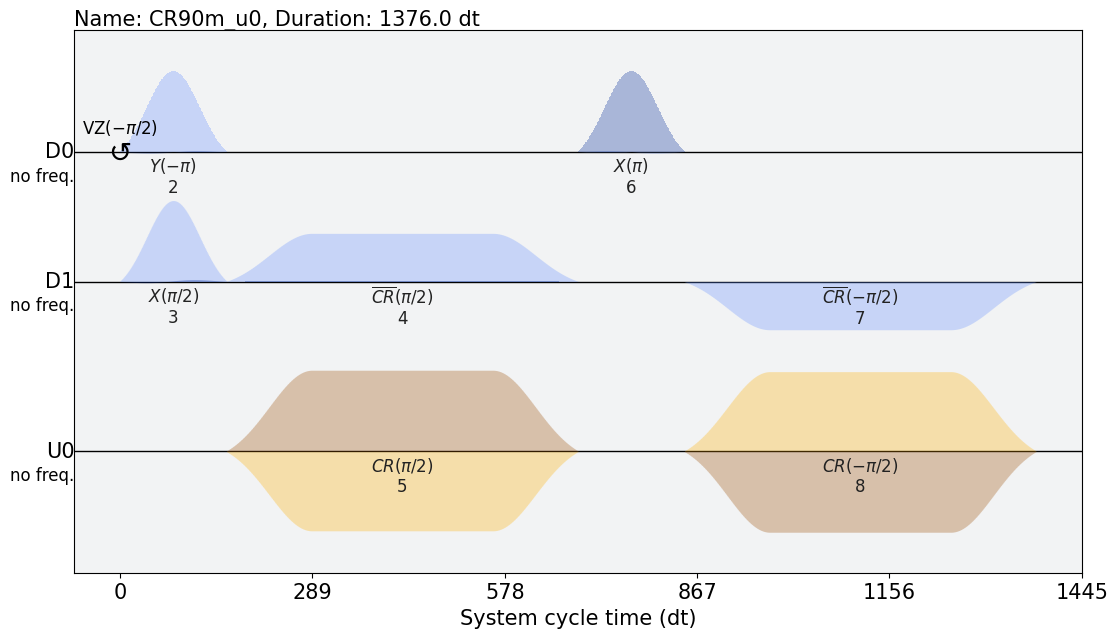

In [16]:
cnot_pm = PulseManipulator(cnot_schedule, backend=lagos)
cnot_pm.draw()

In [17]:
# PulseVisualization
class PulseVisualization:
    """"""
    
    def __init__(self, schedule, backend=None):
        self._init_schedule = copy.deepcopy(schedule)
        self._schedule = copy.deepcopy(schedule)
        self._id_to_scheduled_inst_map = None
        self._set_id_to_scheduled_inst_map()
        self._backend = None
        self._drive_channel_to_control_channels_map = None
        self._control_channel_to_drive_channel_map = None
        self.set_backend(backend)

        
    def copy(self):
        """Copies current and init schedules over to a new PulseVisualization."""
        pv_copy = PulseVisualization(self._schedule,backend=self._backend)
        pv_copy._init_schedule = self._init_schedule
        return pv_copy
        

    def _convert_to_latex(self, instruction, instruction_id=None):
        """Gets LaTeX name corresponding to instruction, adding a conditional instruction ID."""
        if isinstance(instruction, qiskit.pulse.Play):
            pulse_name, sign, channels = re.split("(m|p)+", instruction.name)
            sign = sign.replace("m", "-").replace("p", "")
            symbol, angle, _ = pulse_name.partition("90")
            angle = sign + "\pi" + ("/2" if angle == "90" else "")
            if len(channels.split("_")) > 2:
                latex = f"$\overline{{{symbol}}}({angle})$"
            else:
                latex = f"${symbol}({angle})$"
            if instruction_id is None:
                return latex
            printv(f"label: ({instruction_id}: {latex})")
            return f"{instruction_id}: {latex}"
        return instruction.name


    def _schedule_instruction(
        self, instruction, start_time, instruction_id=None
    ):
        """Schedules instruction at specified start time."""
        return qiskit.pulse.Play(
            type(instruction.pulse)(
                **instruction.pulse.parameters,
                name=self._convert_to_latex(instruction, instruction_id=instruction_id)
            ),
            instruction.channel,
            instruction.name,
        ) << start_time


    def _get_new_instruction(self, instruction, flip_sign=False):
        """Gets copy of instruction with necessary modifications."""
        instruction = copy.deepcopy(instruction)
        if flip_sign:
            instruction.pulse._amp *= -1
            instruction._name = instruction.name.replace("m", "%").replace("p", "m").replace("%", "p")        
        return instruction

    
    def _set_id_to_scheduled_inst_map(self, schedule=None, label_instructions=True, inplace=True):
        """Adds unique IDs to pulse for each Play instruction, creating a new pulse schedule."""
        # Consider default dict for building id_to_scheduled_instruction
        schedule = self._schedule if schedule is None else schedule
        schedule_copy = copy.deepcopy(schedule)
        id_to_scheduled_inst_map = {}
        printv(f"original: {schedule_copy.instructions}")
        printv("=" * 80)
        for idx, (start_time, old_instruction) in enumerate(schedule.instructions):
            printv("=" * 80)
            printv(f"new: {schedule_copy.instructions}")
            printv(f"{idx}: start={start_time}")
            printv(f"old inst: {old_instruction.name}")
            old_scheduled_instruction = old_instruction << start_time
            if (
                not isinstance(
                    old_instruction, qiskit.pulse.Play
                ) or isinstance(old_instruction.channel, qiskit.pulse.MeasureChannel)
            ):
                printv(f"skipping non-Play inst ({old_instruction})...")
                continue
            new_instruction = self._get_new_instruction(old_instruction)
            printv(f"new inst: {new_instruction.name}")
            printv(f"label instructions?: {label_instructions}")
            id_to_scheduled_inst_map[idx] = self._schedule_instruction(
                new_instruction, start_time, instruction_id=idx if label_instructions else None
            )
            printv(f"inst to replace: {old_instruction}")
            printv(f"replacement inst: {id_to_scheduled_inst_map[idx].instructions[0][1]}")
            # Probably need to do the maximum time range (but the start will be the same)
            filtered_copy = schedule_copy.filter(
                lambda inst: not isinstance(inst[1], qiskit.pulse.ShiftPhase),
                channels=[old_instruction.channel],
                time_ranges=[(start_time, start_time + old_instruction.duration)]
            )
            replaced_copy = filtered_copy.replace(
                old_instruction,
                id_to_scheduled_inst_map[idx].instructions[0][1],
            )
            remainder = schedule_copy.exclude(
                lambda inst: inst[0] == start_time and inst[1] == old_instruction
            )
            schedule_copy = replaced_copy | remainder
        printv(f"ids: {id_to_scheduled_inst_map.keys()}")
        if not inplace:
            return schedule_copy
        self._schedule = schedule_copy
        self._id_to_scheduled_inst_map = id_to_scheduled_inst_map


    def set_backend(self, backend):
        """Sets backend.
        
        This is only necessary for insert_instruction method, which needs to know which physical drive
        channel is used for any given control channel.
        """
        self._backend = backend
        self._set_channel_maps(backend)

    def get_stop_time(self, instruction_id=None):
        return self.get_start_time(instruction_id=instruction_id) + self.get_duration(instruction_id=instruction_id)
        
    def get_start_time(self, instruction_id=None):
        start_time, _ = self.get_instruction_and_start_time(instruction_id=instruction_id)
        return start_time
    
    def get_duration(self, instruction_id=None):
        _, inst = self.get_instruction_and_start_time(instruction_id=instruction_id)
        return inst.duration

    @property
    def duration(self):
        """Gets duration (dt) of pulse schedule."""
        return self._schedule.duration
    
    
    def draw(self, time_range=None):
        """Draws pulse schedule, with only time_range parameter currently supported."""
        return self._schedule.draw(time_range=time_range)

    
    def get_qiskit_schedule(self):
        """Returns copy of underlying qiskit pulse schedule."""
        return copy.deepcopy(self._schedule)

    
    def remove_ids(self, inplace=True):
        """Removes unique pulse identifiers."""
        if inplace:
            self._set_id_to_scheduled_inst_map(label_instructions=False)
            return self
        else:
            schedule = self._set_id_to_scheduled_inst_map(inplace=False)
            pv = PulseVisualization(schedule, backend=self._backend)
            pv.remove_ids()
            return pv
        
    
    def flip_amplitude(self, instruction_id=None, inplace=True):
        """Flips amplitude of specified instruction pulse."""
        #TODO: make a stretch_pulse method following this design
        assert (
            self._id_to_scheduled_inst_map.get(instruction_id) is not None
        ), f"You need to supply a valid instruction ID. Choose one of {list(self._id_to_scheduled_inst_map.keys())}."
        old_scheduled_instruction = self._id_to_scheduled_inst_map.get(instruction_id)
        start_time, old_instruction = self.get_instruction_and_start_time(instruction_id=instruction_id)
        new_instruction = self._get_new_instruction(old_instruction, flip_sign=True)
        new_scheduled_instruction = self._schedule_instruction(
            new_instruction,
            start_time,
            instruction_id=instruction_id,
        )
        printv("=" * 80)
        printv(f"Start time: {start_time}")
        printv(f"old instruction: {old_instruction.name}")
        printv(f"new instruction: {new_scheduled_instruction.instructions[0][1].name}")
        filtered_copy = self._schedule.filter(
            lambda inst: not isinstance(inst[1], qiskit.pulse.ShiftPhase),
            channels=[old_instruction.channel],
            time_ranges=[(start_time, start_time + old_instruction.duration)]
        )
        replaced_copy = filtered_copy.replace(
            old_instruction,
            new_scheduled_instruction.instructions[0][1],
        )
        remainder = self._schedule.exclude(
            lambda inst: inst[0] == start_time and inst[1] == old_instruction
        )
        schedule = replaced_copy | remainder
        if inplace:
            self._schedule = schedule
            self._id_to_scheduled_inst_map[instruction_id] = new_scheduled_instruction
            return self
        else:
            return PulseVisualization(schedule, backend=self._backend)


    def reset(self):
        """Reset to original schedule."""
        self._set_id_to_scheduled_inst_map(self._init_schedule)
        return self


    def _set_channel_maps(self, backend):
        """For a given backend, gets map from (logical) control channels to physical drive channels.
        
        Assumptions:
        * each control channel corresponds to a single drive channel
        * any given drive channel may be assigned multiple control channels
        """
        if backend is None:
            return None
        drive_channel_to_control_channels_map = {}
        control_channel_to_drive_channel_map = {}
        for qubits, control_channels in backend.configuration().control_channels.items():
            drive_qubit, _ = qubits
            drive_channel_to_control_channels_map[
                qiskit.pulse.DriveChannel(drive_qubit)
            ] = drive_channel_to_control_channels_map.get(qiskit.pulse.DriveChannel(drive_qubit), []) + control_channels
            control_channel_to_drive_channel_map[control_channels[0]] = qiskit.pulse.DriveChannel(drive_qubit)
        self._drive_channel_to_control_channels_map = drive_channel_to_control_channels_map
        self._control_channel_to_drive_channel_map = control_channel_to_drive_channel_map


    def _find_insertion_point(self, start_time, *channels):
        """Finds pair of scheduled instructions on a given channel between which a new instruction can be
        scheduled.
        """
        scheduled_instructions = self._schedule.filter(channels=[*channels]).instructions
        printv(f"start: {start_time}")
        for idx in range(len(scheduled_instructions) - 1):
            left_start, left_instruction = scheduled_instructions[idx]
            right_start, right_instruction = scheduled_instructions[idx + 1]
            printv("=" * 80)
            printv(f"left inst: {left_instruction.name}")
            printv(f"left start: {left_start}")
            printv(f"left stop: {left_start + left_instruction.duration}")
            printv(f"right inst: {right_instruction.name}")
            printv(f"right start: {right_start}")
            printv(f"right stop: {right_start + right_instruction.duration}")
            if start_time >= left_start + left_instruction.duration and start_time <= right_start:
                printv(f"start is between left stop and right start")
                return scheduled_instructions[idx], scheduled_instructions[idx + 1]
            if start_time > left_start and start_time < left_start + left_instruction.duration:
                printv(f"start overlaps with left")
                return scheduled_instructions[idx], scheduled_instructions[idx]
            if start_time > right_start and start_time < right_start + right_instruction.duration:
                printv(f"start overlaps with right")
                return scheduled_instructions[idx + 1], scheduled_instructions[idx + 1]


    def _perform_insertion(
        self,
        start_time,
        instruction,
        left_scheduled_instruction,
        right_scheduled_instruction,
        *channels,
    ):
        """Inserts instruction between two scheduled instructions.
        
        Assumes start time is valid: greater than stop time of left instruction and less than start time of right
        instruction.
        """
        left_start, left_instruction = left_scheduled_instruction
        right_start, _ = right_scheduled_instruction
        left_half = self._schedule.filter(
            channels=[*channels]
        ).filter(time_ranges=[(0, left_start + left_instruction.duration)])
        right_half = self._schedule.filter(
            channels=[*channels]
        ).filter(time_ranges=[(left_start + left_instruction.duration, self._schedule.duration)])
        left_half_with_insert = left_half.insert(start_time, instruction)
        shift_amount = max(0, left_start + left_half_with_insert.duration - right_start)
        new_schedule = (
            left_half_with_insert
            | right_half.shift(shift_amount)
            | copy.deepcopy(self._schedule.exclude(channels=[*channels]))
        )
        return new_schedule


    def insert_instruction(self, start_time, instruction, inplace=True):
        """Tries to insert instruction at requested start time, shifting all other instructions forward by
        its duration.

        If desired start time is between two instructions, insert it there. Otherwise, won't support inserting an
        instruction in the middle of an existing one (for now).
        """
        assert start_time >= 0, "Start time must be non-negative."
        assert isinstance(instruction, qiskit.pulse.Play), "The instruction must be a qiskit.pulse.Play instruction."
        assert self._backend is not None, "You need to provide a backend. Use PulseVisualization.set_backend"
        instruction = self._get_new_instruction(instruction)
        if instruction.channel not in self._schedule.channels or start_time >= self.duration:
            new_schedule = self._schedule.insert(start_time, instruction)
        elif start_time == 0:
            new_schedule = self._schedule.shift(instruction.duration).insert(start_time, instruction)
        else:
            if isinstance(instruction.channel, qiskit.pulse.DriveChannel):
                channels_to_add = self._drive_channel_to_control_channels_map[instruction.channel]
            elif isinstance(instruction.channel, qiskit.pulse.ControlChannel):
                channels_to_add = self._control_channel_to_drive_channel_map[instruction.channel]
            else:
                raise ValueError("Only mid-schedule insertions on DriveChannel and ControlChannel are currently supported.")
            left_scheduled_instruction, right_scheduled_instruction = self._find_insertion_point(
                start_time, instruction.channel, *channels_to_add
            )
            left_start, left_instruction = left_scheduled_instruction
            right_start, right_instruction = right_scheduled_instruction
            assert (
                left_scheduled_instruction != right_scheduled_instruction
            ), (
                f"This start time ({start_time}dt) overlaps with an existing instruction ({left_instruction.name}) from {left_start}dt to "
                f"{left_start + left_instruction.duration}dt."
            )
            new_schedule = self._perform_insertion(
                start_time,
                instruction,
                left_scheduled_instruction,
                right_scheduled_instruction,
                instruction.channel,
                *channels_to_add,
            )
        if not inplace:
            return PulseVisualization(new_schedule, backend=self._backend)
        else:
            self._set_id_to_scheduled_inst_map(schedule=new_schedule)
            return self


    def get_instruction_and_start_time(self, instruction_id=None):
        """Given scheduled instruction ID, gets start time and instruction."""
        assert (
            self._id_to_scheduled_inst_map.get(instruction_id) is not None
        ), f"You need to supply a valid instruction ID. Choose one of {list(self._id_to_scheduled_inst_map.keys())}."
        ((start_time, instruction),) = self._id_to_scheduled_inst_map.get(instruction_id).instructions
        return start_time, instruction

    
    def get_instruction_name(self, instruction_id=None):
        """Gets name for instruction."""
        _, instruction = self.get_instruction_and_start_time(instruction_id=instruction_id)
        return instruction.name
    

    def get_instruction_pulse(self, instruction_id=None):
        """Gets copy of underlying pulse for given instruction.
        
        E.g., see actual pulse for an instruction following a frame change.
        """
        _, instruction = self.get_instruction_and_start_time(instruction_id=instruction_id)
        return copy.deepcopy(instruction.pulse)

    
    def get_instruction_waveform_samples(self, instruction_id=None):
        """Gets waveform samples for instruction pulse."""
        pulse = self.get_instruction_pulse(instruction_id=instruction_id)
        return pulse.get_waveform().samples
    

    def get_instruction_start_time(self, instruction_id=None):
        """Gets start time (in units of dt, cycle time) for instruction."""
        start_time, _ = self.get_instruction_and_start_time(instruction_id=instruction_id)
        return start_time


    def get_instruction_duration(self, instruction_id=None):
        """Gets duration (dt) for instruction."""
        _, instruction = self.get_instruction_and_start_time(instruction_id=instruction_id)
        return instruction.duration


    def get_instruction_stop_time(self, instruction_id=None):
        """Gets end time (dt) for instruction."""
        return self.get_instruction_start_time(instruction_id=instruction_id) + self.get_instruction_duration(instruction_id=instruction_id)        


    def get_parameters(self, instruction_id=None):
        """Gets parameters dictionary for instruction pulse."""
        _, instruction = self.get_instruction_and_start_time(instruction_id)
        if instruction.pulse.parameters:
            return instruction.pulse.parameters
        
    
    def get_amplitude(self, instruction_id=None):
        """Returns complex amplitude of instruction pulse."""
        _, instruction = self.get_instruction_and_start_time(instruction_id=instruction_id)
        return instruction.pulse.amp
    
    
    def get_sigma(self, instruction_id=None):
        """Returns standard deviation for underlying Gaussian (i.e., measures width of peak)"""
        _, instruction = self.get_instruction_and_start_time(instruction_id=instruction_id)
        return instruction.pulse.sigma

    
    def get_beta(self, instruction_id=None):
        """Returns correction amplitude for underlying Gaussian (i.e., mitigates leakage error)"""
        _, instruction = self.get_instruction_and_start_time(instruction_id=instruction_id)
        assert isinstance(instruction.pulse, qiskit.pulse.Drag), "Only qiskit.pulse.Drag pulses have the beta parameter."
        return instruction.pulse.beta
    
    
    def get_width(self, instruction_id=None):
        """Returns square pulse width for underlying GaussianSquare (i.e., square pulse with Gaussian edges)"""
        _, instruction = self.get_instruction_and_start_time(instruction_id=instruction_id)
        assert isinstance(instruction.pulse, qiskit.pulse.GaussianSquare), "Only qiskit.pulse.GaussianSquare pulses have the width parameter."
        return instruction.pulse.width
    

    def measure(self, with_delay=True, remove_acquires=False):
        """"""
        #TODO: use self.insert_instruction (similarly for self.measure_all)
        assert self._backend is not None, "You need to provide a backend. Use PulseVisualization.set_backend"
        qubits = [channel.index for channel in self._schedule.channels if isinstance(channel, qiskit.pulse.DriveChannel)]
        ism = self._backend.defaults().instruction_schedule_map
        schedule_copy = copy.deepcopy(self._schedule)
        for qubit in qubits:
            for start, inst in ism.get("measure", qubit).instructions:
                if qubit == qubits[0]:
                    if remove_acquires and isinstance(inst, qiskit.pulse.Acquire):
                        if inst.channel == qiskit.pulse.AcquireChannel(qubit):
                            printv(f"found an acquire: {inst}\n")
                            schedule_copy.insert(self.duration + start, inst, inplace=True)
                    elif not isinstance(inst, qiskit.pulse.Delay):
                        printv(f"adding an inst: {inst}\n")
                        schedule_copy.insert(self.duration + start, inst, inplace=True)
                    else:
                        if with_delay:
                            printv(f"get delays: {inst}\n")
                            schedule_copy.insert(self.duration + start, inst, inplace=True)
                elif qubit != qubits[0] and isinstance(inst, qiskit.pulse.Play):
                    printv(f"plays only: {inst}\n")
                    schedule_copy.insert(self.duration + start, inst, inplace=True)
        self._schedule = schedule_copy
        self._set_id_to_scheduled_inst_map()
        return self


    def shift_channel():
        """Shift instructions in a channel forwards in time."""
        #TODO: similar to last part of self.insert_instruction
        pass
    
import warnings
warnings.filterwarnings("ignore")

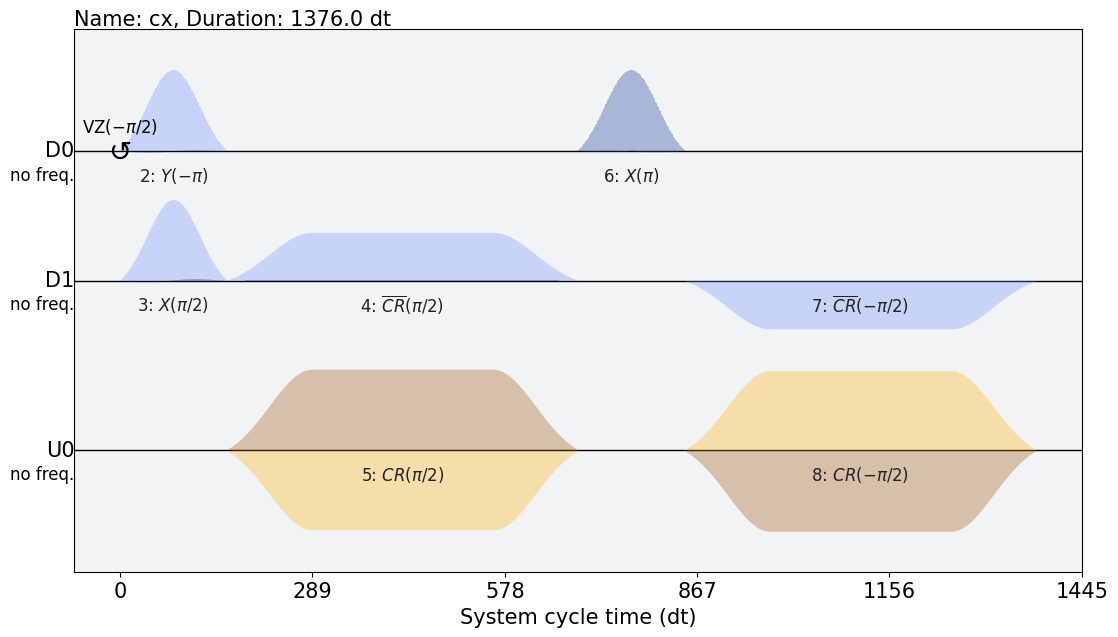

In [18]:
cnot_pv = PulseVisualization(cnot_schedule, backend=lagos)
cnot_pv.draw()

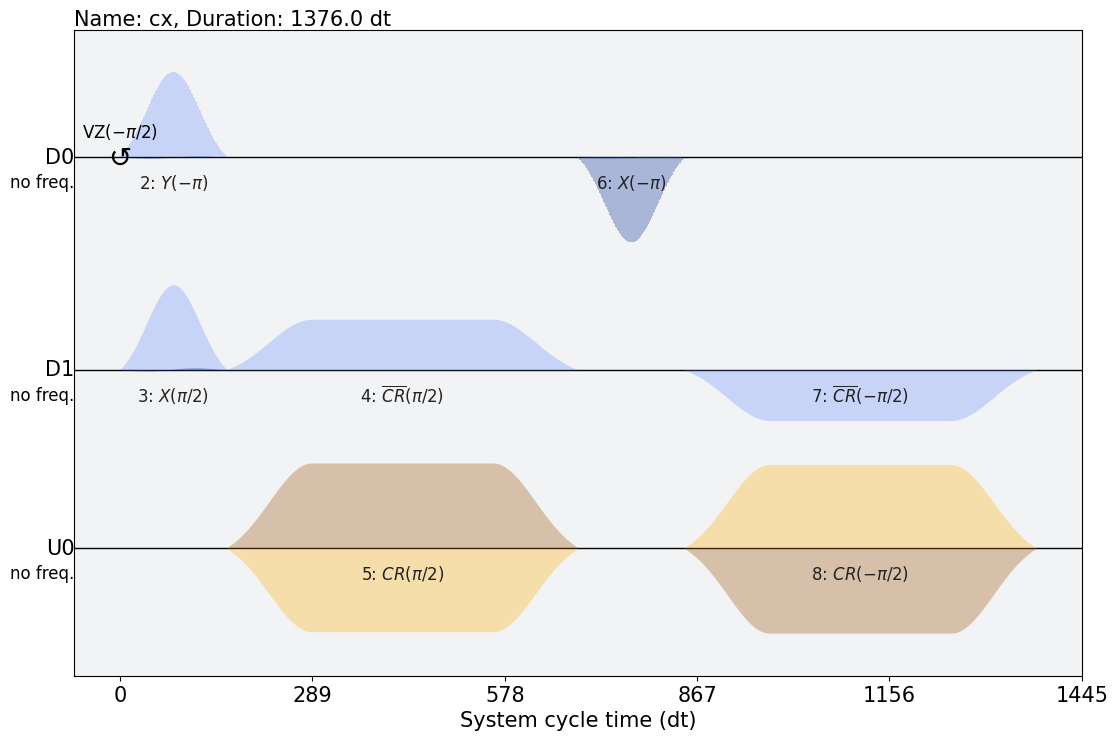

In [19]:
# cnot_pm.replace(inst_id=6, flip_amp=True).draw()
cnot_pv.flip_amplitude(instruction_id=6).draw()

## Qiskit Pulse: Inserting an instruction

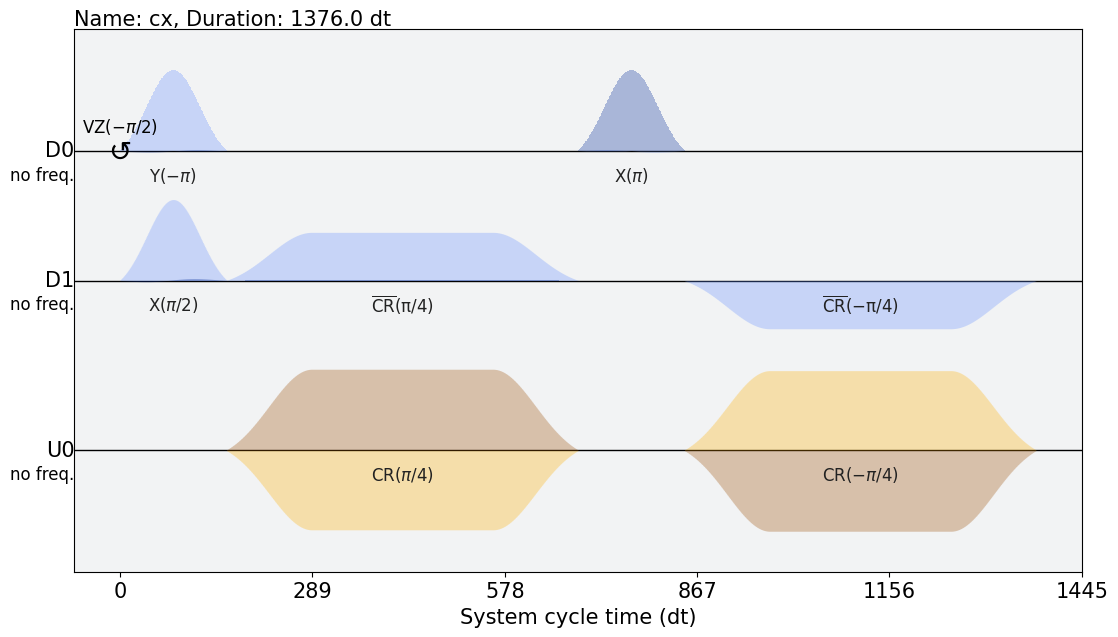

In [20]:
cnot_schedule.draw()

In [21]:
# schedule.instructions of form ((start_time, inst), (start_time, inst), ...)
cnot_copy = copy.deepcopy(cnot_schedule)
for idx, (start, instruction) in enumerate(cnot_copy.instructions):
    print(f"({idx}) {start}: {instruction}\n")

(0) 0: ShiftPhase(1.5707963267948966, DriveChannel(0))

(1) 0: ShiftPhase(1.5707963267948966, ControlChannel(1))

(2) 0: Play(Drag(duration=160, amp=(-5.0087850715881974e-17-0.2726655595760622j), sigma=40, beta=-1.0274239451049492, name='Ym_d0'), DriveChannel(0), name='Ym_d0')

(3) 0: Play(Drag(duration=160, amp=(0.10007125765951656+0.000855337357655086j), sigma=40, beta=-1.406580665674364, name='X90p_d1'), DriveChannel(1), name='X90p_d1')

(4) 160: Play(GaussianSquare(duration=528, amp=(0.059534361985564166+0.00028203014994330713j), sigma=64, width=272, name='CR90p_d1_u0'), DriveChannel(1), name='CR90p_d1_u0')

(5) 160: Play(GaussianSquare(duration=528, amp=(-0.681022576091795+0.6931477142917915j), sigma=64, width=272, name='CR90p_u0'), ControlChannel(0), name='CR90p_u0')

(6) 688: Play(Drag(duration=160, amp=(0.2726655595760622+0j), sigma=40, beta=-1.0274239451049492, name='Xp_d0'), DriveChannel(0), name='Xp_d0')

(7) 848: Play(GaussianSquare(duration=528, amp=(-0.059534361985564166-

In [22]:
inst_id = 4
print(f"pulse: {cnot_copy.instructions[inst_id][1].name}")
print(f"start: {cnot_copy.instructions[inst_id][0]}")
print(f"duration: {cnot_copy.instructions[inst_id][1].duration}")
print(f"stop time: {cnot_copy.instructions[inst_id][0] + cnot_copy.instructions[inst_id][1].duration}")

pulse: CR90p_d1_u0
start: 160
duration: 528
stop time: 688


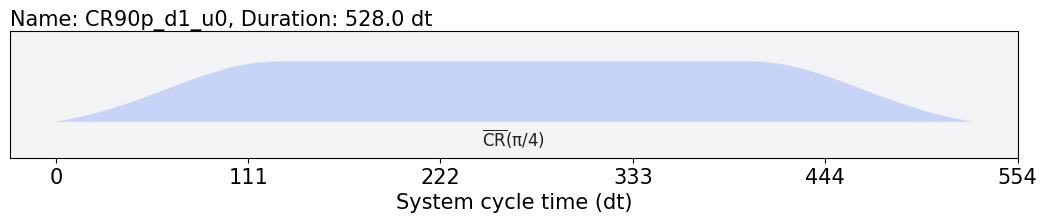

In [23]:
cnot_copy.instructions[inst_id][1].pulse.draw()

### Instructions to try inserting:

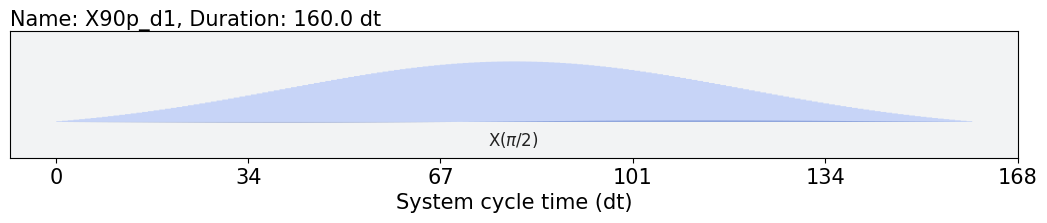

In [24]:
sx_1_inst = ism.get("sx", 1).instructions[0][1]
sx_1_inst.pulse.draw()

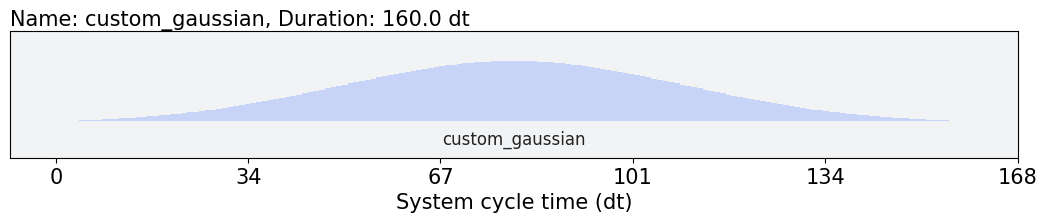

In [25]:
custom_gaussian_inst = qiskit.pulse.Play(
    qiskit.pulse.Gaussian(duration=160, amp=1, sigma=30, name="custom_gaussian"),
    qiskit.pulse.DriveChannel(1),
    name="custom_inst"
)
custom_gaussian_inst.pulse.draw()

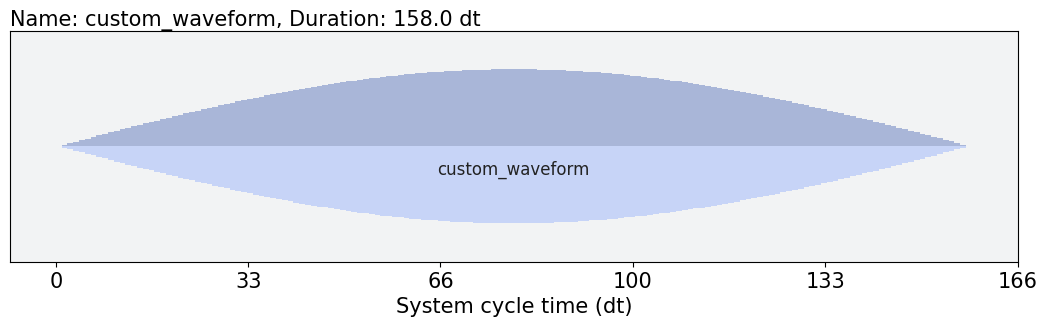

In [26]:
# (1/2) * [cos(2x + pi/2)+ i*sin(2x)]
samples = np.array([np.cos(2*x + np.pi / 2) / 2 + 1j * np.sin(2*x) / 2 for x in np.arange(0, np.pi / 2, 0.01)])
custom_pulse = qiskit.pulse.Waveform(
    samples=samples,
    name="custom_waveform"
)
custom_inst = qiskit.pulse.Play(custom_pulse, channel=qiskit.pulse.DriveChannel(1))
custom_inst.pulse.draw()

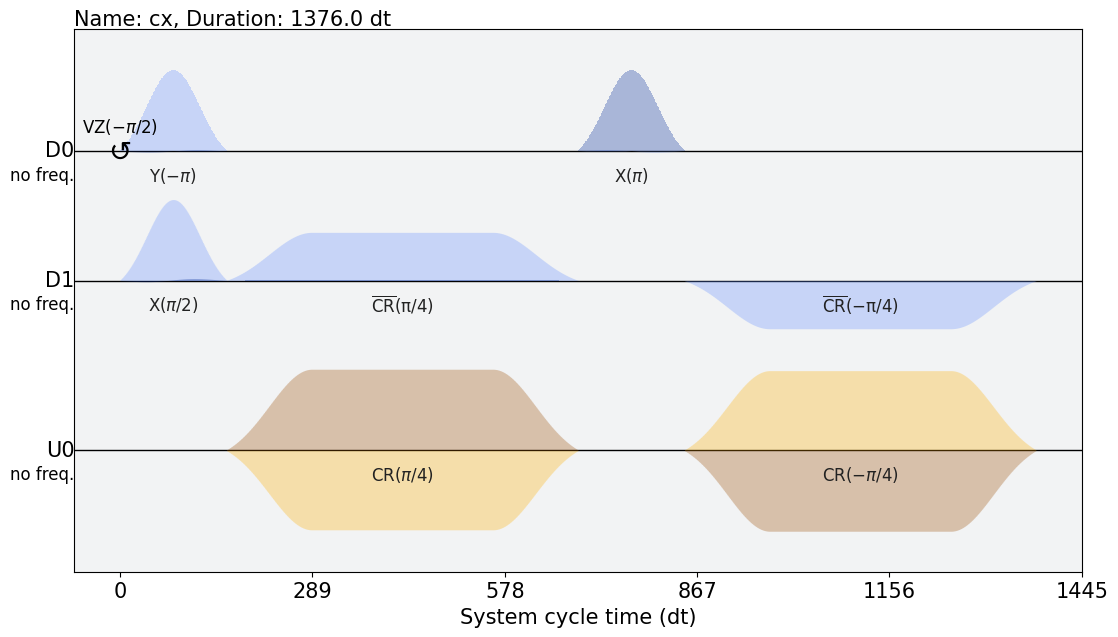

In [27]:
cnot_copy.draw()

In [28]:
print(f"start time: {cnot_copy.instructions[inst_id][0]}")
print(f"stop time: {cnot_copy.instructions[inst_id][0] + cnot_copy.instructions[inst_id][1].duration}")

start time: 160
stop time: 688


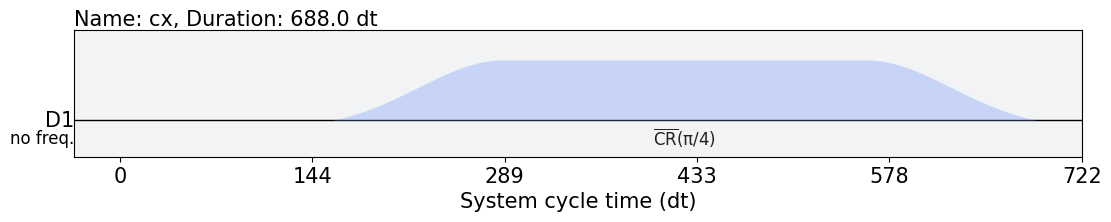

In [29]:
cnot_copy.filter(time_ranges=[(160, 688)], channels=[cnot_copy.instructions[inst_id][1].channel]).draw()

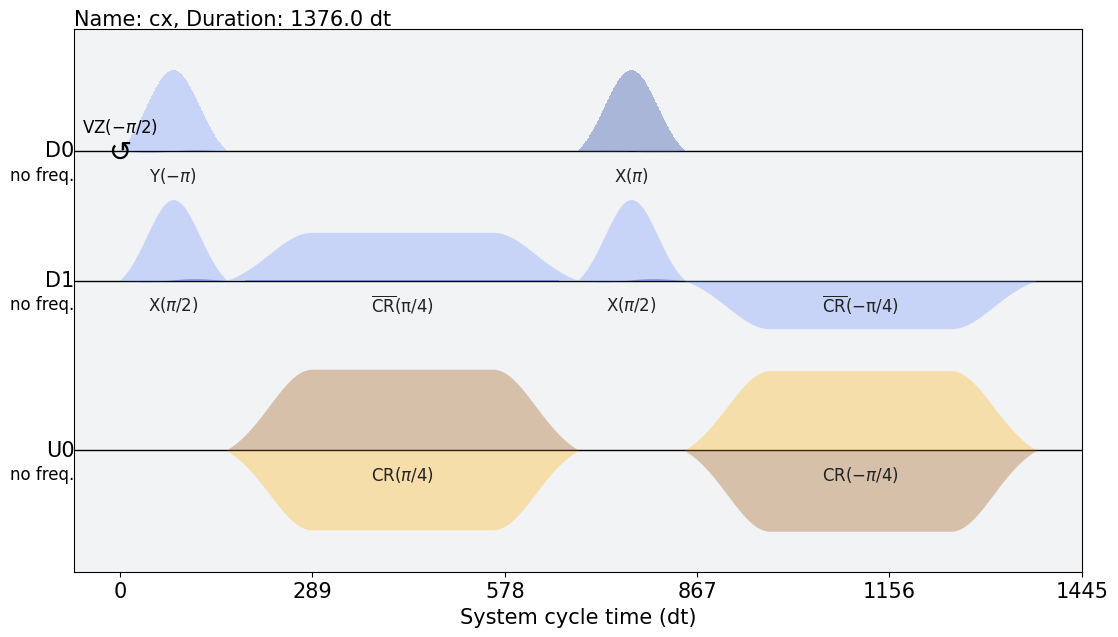

In [30]:
cnot_copy.insert(688, sx_1_inst).draw()

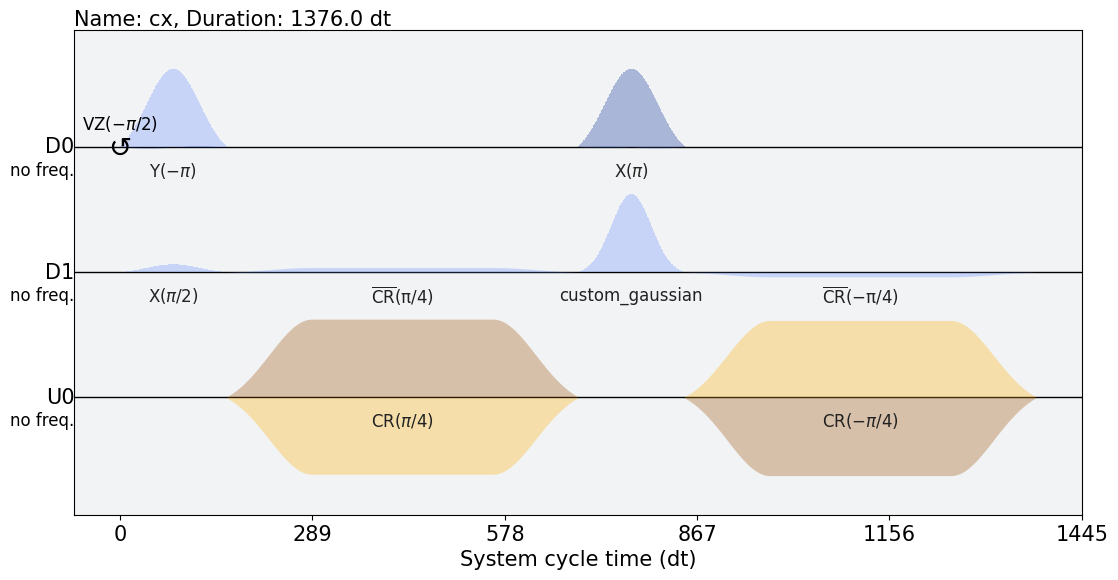

In [31]:
cnot_copy.insert(688, custom_gaussian_inst).draw()

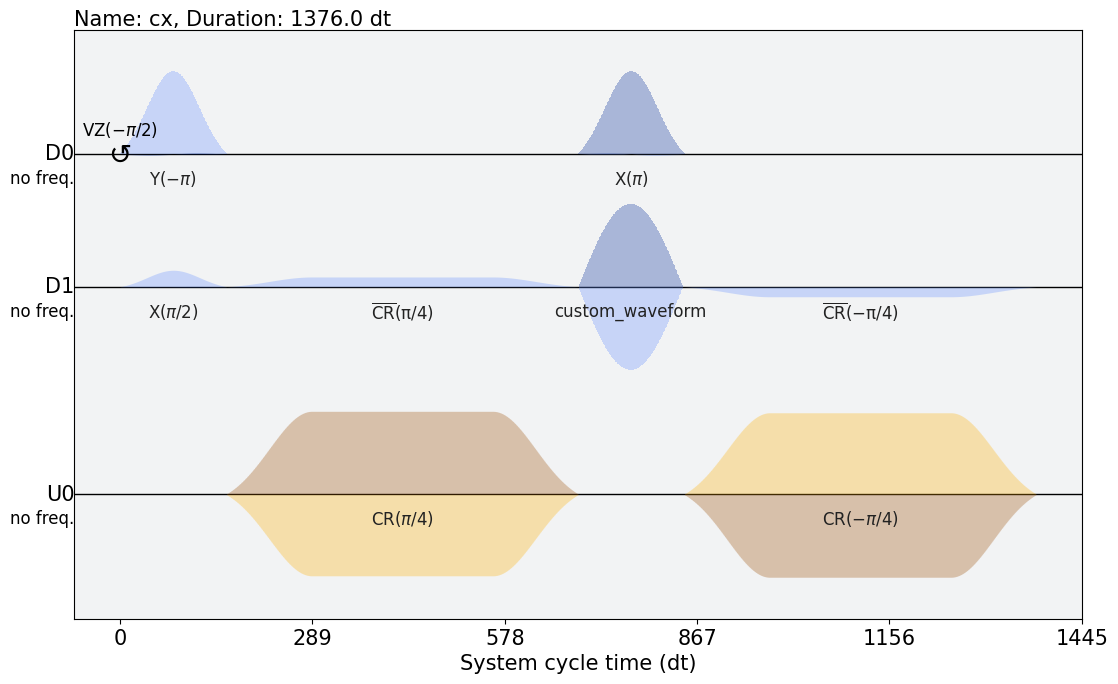

In [32]:
cnot_copy.insert(688, custom_inst).draw()

### Adding instructions to control channel

In [33]:
inst_id = 5
print(f"pulse: {cnot_copy.instructions[inst_id][1].name}")
print(f"start: {cnot_copy.instructions[inst_id][0]}")
print(f"duration: {cnot_copy.instructions[inst_id][1].duration}")
print(f"stop time: {cnot_copy.instructions[inst_id][0] + cnot_copy.instructions[inst_id][1].duration}")

pulse: CR90p_u0
start: 160
duration: 528
stop time: 688


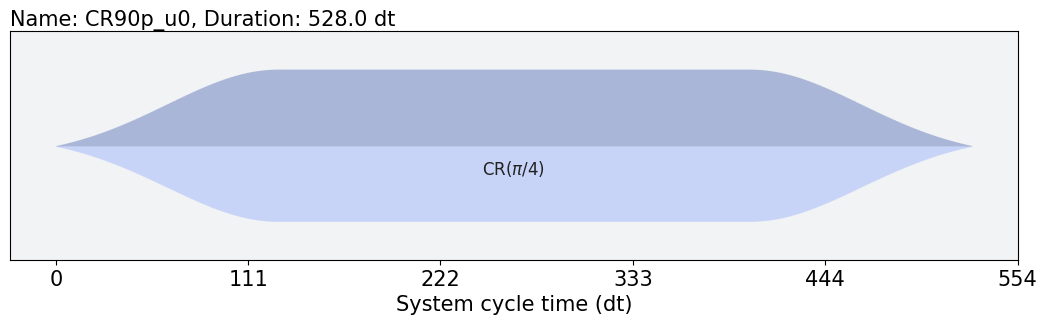

In [34]:
cnot_copy.instructions[inst_id][1].pulse.draw()

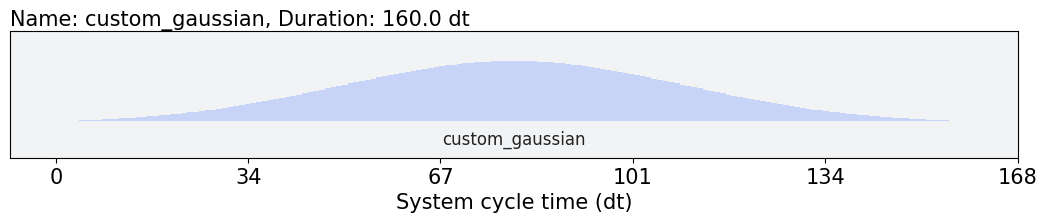

In [35]:
custom_gaussian_u0 = qiskit.pulse.Play(
    qiskit.pulse.Gaussian(duration=160, amp=1, sigma=30, name="custom_gaussian"),
    qiskit.pulse.ControlChannel(0),
    name="custom_inst"
)
custom_gaussian_u0.pulse.draw()

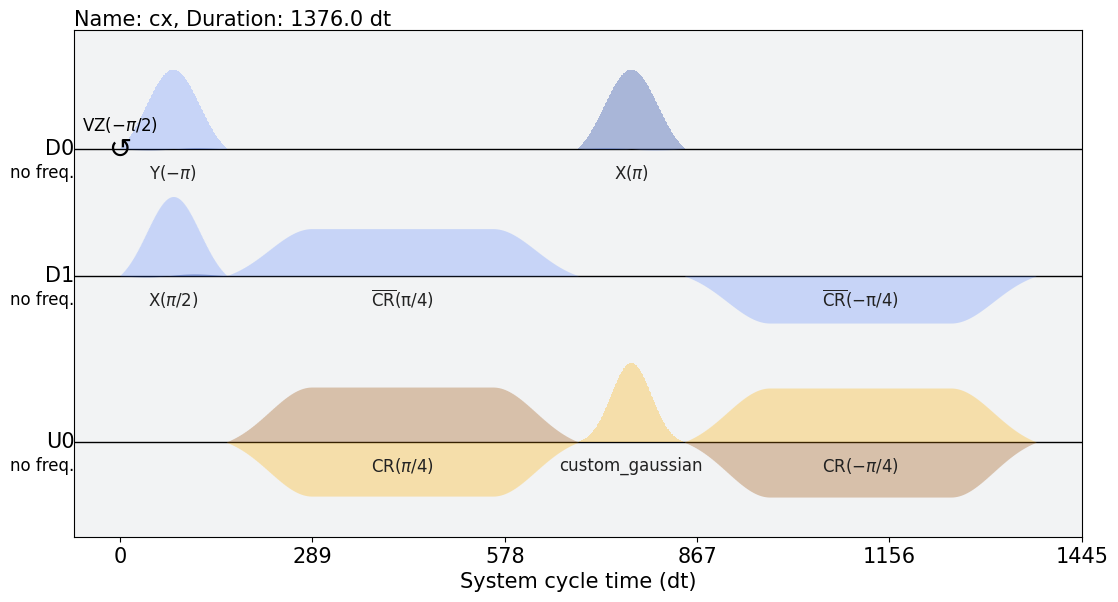

In [36]:
cnot_copy.insert(688, custom_gaussian_u0).draw()

In [37]:
lagos.configuration().control_channels

{(0, 1): [ControlChannel(0)],
 (1, 0): [ControlChannel(1)],
 (5, 6): [ControlChannel(10)],
 (6, 5): [ControlChannel(11)],
 (1, 2): [ControlChannel(2)],
 (1, 3): [ControlChannel(3)],
 (2, 1): [ControlChannel(4)],
 (3, 1): [ControlChannel(5)],
 (3, 5): [ControlChannel(6)],
 (4, 5): [ControlChannel(7)],
 (5, 3): [ControlChannel(8)],
 (5, 4): [ControlChannel(9)]}

In [38]:
lagos.configuration().control((0, 1))

[ControlChannel(0)]

## (SuperstaQ)PulseVisualization: insert instruction

In [ ]:
# cnot_pv.draw()
cnot_pm.draw()

In [ ]:
# cnot_pv.get_stop_time(instruction_id=4)
cnot_pm.get_stop_time(inst_id=4)

In [ ]:
print(f"basis gates: {lagos.configuration().basis_gates}")
sx_1 = ism.get("sx", 1).instructions[0][1]
sx_1.pulse.draw()

In [ ]:
# cnot_pv.insert_instruction(688, sx_1).draw()
cnot_pm.insert(688, sx_1).draw()

In [ ]:
# cnot_pv.shift(300).draw()
# cnot_pm.shift(300).draw()
cnot_pm.shift(300, channel=qiskit.pulse.DriveChannel(1)).draw()

In [ ]:
cnot_pv.flip_amplitude(instruction_id=4).draw()
# cnot_pm.replace(inst_id=4, flip_amp=True).draw()

In [ ]:
cnot_pv.insert_instruction(0, sx_1).draw()
# cnot_pm.insert_instruction(0, sx_1).draw()

In [ ]:
cnot_pv.insert_instruction(cnot_pv.duration, sx_1).draw()
# cnot_pm.insert_instruction(cnot_pm.duration, sx_1).draw()

In [ ]:
cnot_pv.measure().draw()
# cnot_pm.measure().draw()

In [ ]:
qiskit_schedule = cnot_pv.remove_ids(inplace=False).get_qiskit_schedule()
# qiskit_schedule = cnot_pm.get_qiskit_schedule()
qiskit_schedule.draw()

In [ ]:
# cnot_pm.get_instruction_start_time(5)
cnot_pv.get_instruction_start_time(5)

In [ ]:
# cnot_pm.get_instruction_stop_time(5)
cnot_pv.get_instruction_stop_time(5)

In [ ]:
qiskit_schedule.exclude(channels=[qiskit.pulse.DriveChannel(1)], time_ranges=[(320, 848)]).draw()

In [ ]:
job_0 = lagos.retrieve_job("6324d1076b619aa6990d4477")  # cnot with random additions (not the one above)
# job_0 = lagos.run(qiskit_schedule, shots=1000)
print(job_0.job_id())
job_0.status()

In [ ]:
plot_histogram(job_0.result().get_counts(), figsize=(30, 10))

## Validate PulseVisualization w/ simple job

### (This first batch is before I fixed the `PulseVisualization.measure` bug)

In [ ]:
sx_pv = PulseVisualization(ism.get("sx", 0), backend=lagos)
# sx_pm = PulseManipulator(ism.get("sx", 0), backend=lagos)
sx_pv.draw()

In [ ]:
# sx_pm.measure().draw()
sx_pv.measure().draw()

In [ ]:
# sx = sx_pm.get_qiskit_schedule()
sx = sx_pv.remove_ids(inplace=False).get_qiskit_schedule()
sx.draw()

In [ ]:
# sxm = sx_pm.replace(inst_id=0, flip_amp=True).get_qiskit_schedule()
sxm = sx_pv.flip_amplitude(instruction_id=0, inplace=False).remove_ids(inplace=False).get_qiskit_schedule()
sxm.draw()

In [ ]:
# job_1 = lagos.run([sx, sxm])
job_1 = lagos.retrieve_job("6324d40e95ea07aa42482eeb")  # measure w/ delay
# job_1 = lagos.retrieve_job("6324d212fcf0f3cf5beaa4b8")  # measure w/o delay

In [ ]:
print(job_1.job_id())
job_1.status()

In [ ]:
plot_histogram(job_1.result().get_counts()[0], figsize=(30, 10))

In [ ]:
plot_histogram(job_1.result().get_counts()[1], figsize=(30, 10))

In [ ]:
### Flip amplitude job (prior to bugfix)

# sx_circ = qiskit.QuantumCircuit(1, 1)
# sx_circ.sx(0)
# sx_circ.measure(0, 0)
# sx_circ.draw()

# sx_circ_schedule = qiskit.schedule(sx_circ, lagos)
# sx_circ_schedule.draw()

# sx_circ_schedule.instructions

# ism.get("measure", qubits=(0,)).instructions

# sxm_circ_schedule = copy.deepcopy(sx_circ_schedule)
# sxm_circ_schedule.instructions[0][1].pulse._amp *= -1
# sxm_circ_schedule.draw()

# job_3 = lagos.run([sx_circ_schedule, sxm_circ_schedule])

# print(job_3.job_id())
# job_3.status()

# plot_histogram(job_3.result().get_counts()[0])
# plot_histogram(job_3.result().get_counts()[1])

# # weird_job = lagos.retrieve_job("6324ceee6b619a90390d4474")
# # plot_histogram(weird_job.result().get_counts()[0], figsize=(30, 10))

## Flip amplitude job

In [ ]:
sx_pv = PulseVisualization(ism.get("sx", 0), backend=lagos)
sx_pv.measure(remove_acquires=True)
sx_pv.draw()

# sx_pm = PulseManipulator(ism.get("sx", 0), backend=lagos)
# sx_pm.measure()
# sx_pm.draw()

In [ ]:
print(f"sx_pv: {type(sx_pv)}")
sx = sx_pv.remove_ids(inplace=False).get_qiskit_schedule()
# sx = sx_pm.get_qiskit_schedule()
print(f"sx qiskit: {type(sx)}")
sx.draw()

In [ ]:
sxm = sx_pv.flip_amplitude(instruction_id=0, inplace=False).remove_ids(inplace=False).get_qiskit_schedule()
# sxm = sx_pm.replace(inst_id=0).get_qiskit_schedule()
sxm.draw()

In [ ]:
# X^(1/2)X^(-1/2) = I
sx_0 = ism.get("sx", 0).instructions[0][1]
# sx_0.pulse.draw()
sx_sxm = sx_pv.flip_amplitude(
    instruction_id=0, inplace=False
).insert_instruction(0, sx_0, inplace=False).get_qiskit_schedule()
# sx_sxm = sx_pm.replace(inst_id=0, flip_amp=True).insert(0, sx_0).get_qiskit_schedule()
sx_sxm.draw()

In [ ]:
# job_4 = lagos.run([sx, sxm, sx_sxm], shots=1000)
job_4 = lagos.retrieve_job("6324ddfd542f5094b21e3b61")  # sx and sxm jobs (no combination)

In [ ]:
print(job_4.job_id())
job_4.status()

In [ ]:
plot_histogram(job_4.result().get_counts()[0])

In [ ]:
plot_histogram(job_4.result().get_counts()[1])

In [ ]:
plot_histogram(job_4.result().get_counts()[2])